In [1]:
!pip install seaborn
!pip install imblearn
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.4 MB/s eta 0:00:00


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)

# ================================
# Data Loading
# ================================

print("Loading data from SQLite database...")

# Connect to the SQLite database
database = '/content/sample_data/database.sqlite'
conn = sqlite3.connect(database)

# Load tables into pandas DataFrames
country = pd.read_sql_query("SELECT * FROM Country", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
match = pd.read_sql_query("SELECT * FROM Match", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

print("Data Loaded Successfully.")

# Close the database connection
conn.close()

# Display basic information
print(f"Number of matches: {match.shape[0]}")
print(f"Number of teams: {team.shape[0]}")
print(f"Number of players: {player.shape[0]}")

# ================================
# Data Preprocessing and Merging
# ================================

# Merge country and league data into match data
match = match.merge(country, how='left', left_on='country_id', right_on='id', suffixes=('', '_country'))
match = match.merge(league, how='left', left_on='league_id', right_on='id', suffixes=('', '_league'))

# Rename columns for clarity
match.rename(columns={'name': 'country_name', 'name_league': 'league_name'}, inplace=True)

# Convert date columns to datetime
match['date'] = pd.to_datetime(match['date'])
team_attributes['date'] = pd.to_datetime(team_attributes['date'])
player_attributes['date'] = pd.to_datetime(player_attributes['date'])
player['birthday'] = pd.to_datetime(player['birthday'])

# Create match outcome variable
# 1 for home win, 0 for draw, -1 for away win
def get_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Home win
    elif row['home_team_goal'] == row['away_team_goal']:
        return 0  # Draw
    else:
        return -1  # Away win

match['match_result'] = match.apply(get_match_result, axis=1)

Loading data from SQLite database...
Data Loaded Successfully.
Number of matches: 25979
Number of teams: 299
Number of players: 11060


In [7]:
# ================================
# Feature Engineering
# ================================

# --- Team Attributes ---

# Define the columns to use from team_attributes
team_attribute_cols = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
    'defenceAggression', 'defenceTeamWidth', 'buildUpPlayPositioningClass',
    'chanceCreationPositioningClass', 'defenceDefenderLineClass'
]

# Prepare team attributes by selecting the most recent attributes before the match date
def get_team_attributes(team_id, match_date):
    attributes = team_attributes[team_attributes['team_api_id'] == team_id]
    attributes = attributes[attributes['date'] <= match_date]
    attributes = attributes.sort_values(by='date', ascending=False)
    if not attributes.empty:
        attributes = attributes.iloc[0]
        return attributes[team_attribute_cols]
    else:
        # Return a Series with NaNs and correct index
        return pd.Series([np.nan]*len(team_attribute_cols), index=team_attribute_cols)

# Apply the function to get team attributes for home and away teams
print("Extracting team attributes...")
home_team_attrs = []
away_team_attrs = []

for idx, row in match.iterrows():
    home_attrs = get_team_attributes(row['home_team_api_id'], row['date'])
    away_attrs = get_team_attributes(row['away_team_api_id'], row['date'])
    home_team_attrs.append(home_attrs)
    away_team_attrs.append(away_attrs)

home_team_attrs_df = pd.DataFrame(home_team_attrs)
away_team_attrs_df = pd.DataFrame(away_team_attrs)

# Add prefixes to columns to distinguish between home and away attributes
home_team_attrs_df = home_team_attrs_df.add_prefix('home_')
away_team_attrs_df = away_team_attrs_df.add_prefix('away_')

# Concatenate the attributes to the match data
match = pd.concat([match.reset_index(drop=True), home_team_attrs_df.reset_index(drop=True), away_team_attrs_df.reset_index(drop=True)], axis=1)

# Check for duplicate columns
duplicate_columns = match.columns[match.columns.duplicated()]
if duplicate_columns.any():
    print(f"Duplicate columns in match DataFrame: {duplicate_columns}")

# --- Player Attributes ---

# Function to get the average player attributes for a team before a match
def get_team_player_attributes(team_id, match_date, player_cols, match_row, team_type):
    # Get player IDs from the team's lineup in the match
    players = []
    for i in range(1, 12):
        player_id = match_row.get(f'{team_type}_player_{i}', None)
        if not pd.isnull(player_id):
            players.append(player_id)
    # Get the most recent attributes for each player
    player_attrs = player_attributes[player_attributes['player_api_id'].isin(players)]
    player_attrs = player_attrs[player_attrs['date'] <= match_date]
    player_attrs = player_attrs.sort_values(by='date', ascending=False).drop_duplicates(subset=['player_api_id'], keep='first')
    # Return the average attributes
    if not player_attrs.empty:
        return player_attrs[player_cols].mean()
    else:
        return pd.Series([np.nan]*len(player_cols), index=player_cols)

print("Extracting player attributes (this may take a while)...")
team_player_attrs = []

# Define player attributes columns to use
player_cols = [
    'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
    'short_passing', 'dribbling', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'agility', 'stamina', 'strength',
    'penalties', 'marking', 'standing_tackle', 'sliding_tackle'
]

# We have expanded the player attributes to include more features

for idx, row in match.iterrows():
    home_player_attrs = get_team_player_attributes(row['home_team_api_id'], row['date'], player_cols, row, 'home')
    away_player_attrs = get_team_player_attributes(row['away_team_api_id'], row['date'], player_cols, row, 'away')
    home_player_attrs = home_player_attrs.add_prefix('home_player_')
    away_player_attrs = away_player_attrs.add_prefix('away_player_')
    combined_attrs = pd.concat([home_player_attrs, away_player_attrs], axis=0)
    team_player_attrs.append(combined_attrs)

team_player_attrs_df = pd.DataFrame(team_player_attrs)

# Concatenate player attributes to match data
match = pd.concat([match.reset_index(drop=True), team_player_attrs_df.reset_index(drop=True)], axis=1)

# --- Recent Team Performance ---

# Function to calculate team's recent performance before a match
def get_recent_performance(team_id, date, n_matches=5):
    team_matches_home = match[(match['home_team_api_id'] == team_id) & (match['date'] < date)]
    team_matches_away = match[(match['away_team_api_id'] == team_id) & (match['date'] < date)]
    team_matches = pd.concat([team_matches_home, team_matches_away]).sort_values(by='date', ascending=False)
    team_matches = team_matches.head(n_matches)
    if not team_matches.empty:
        results = []
        for idx, row in team_matches.iterrows():
            if row['home_team_api_id'] == team_id:
                if row['match_result'] == 1:
                    results.append(1)
                elif row['match_result'] == 0:
                    results.append(0)
                else:
                    results.append(-1)
            else:
                if row['match_result'] == -1:
                    results.append(1)
                elif row['match_result'] == 0:
                    results.append(0)
                else:
                    results.append(-1)
        return np.mean(results)
    else:
        return 0

print("Calculating recent team performance...")
home_recent_performance = []
away_recent_performance = []

for idx, row in match.iterrows():
    home_perf = get_recent_performance(row['home_team_api_id'], row['date'])
    away_perf = get_recent_performance(row['away_team_api_id'], row['date'])
    home_recent_performance.append(home_perf)
    away_recent_performance.append(away_perf)

match['home_recent_performance'] = home_recent_performance
match['away_recent_performance'] = away_recent_performance

# --- Head-to-Head Statistics ---

# Function to calculate head-to-head statistics
def get_head_to_head(home_team_id, away_team_id, date):
    h2h_matches = match[((match['home_team_api_id'] == home_team_id) & (match['away_team_api_id'] == away_team_id)) |
                        ((match['home_team_api_id'] == away_team_id) & (match['away_team_api_id'] == home_team_id))]
    h2h_matches = h2h_matches[h2h_matches['date'] < date].sort_values(by='date', ascending=False)
    h2h_matches = h2h_matches.head(5)
    if not h2h_matches.empty:
        results = []
        for idx, row in h2h_matches.iterrows():
            if row['home_team_api_id'] == home_team_id and row['match_result'] == 1:
                results.append(1)
            elif row['away_team_api_id'] == home_team_id and row['match_result'] == -1:
                results.append(1)
            elif row['match_result'] == 0:
                results.append(0)
            else:
                results.append(-1)
        return np.mean(results)
    else:
        return 0

print("Calculating head-to-head statistics...")
h2h_performance = []

for idx, row in match.iterrows():
    h2h_perf = get_head_to_head(row['home_team_api_id'], row['away_team_api_id'], row['date'])
    h2h_performance.append(h2h_perf)

match['head_to_head'] = h2h_performance

# --- Categorical Encoding ---

# Corrected column names (fixed 'defenceDefensiveLineClass' to 'defenceDefenderLineClass')
categorical_cols = [
    'home_buildUpPlayPositioningClass', 'home_chanceCreationPositioningClass', 'home_defenceDefenderLineClass',
    'away_buildUpPlayPositioningClass', 'away_chanceCreationPositioningClass', 'away_defenceDefenderLineClass'
]

# Replace missing categorical values with a placeholder
for col in categorical_cols:
    if col in match.columns:
        match[col].fillna('Unknown', inplace=True)
        match[col] = match[col].astype('category').cat.codes

# --- Feature Selection ---

# Select relevant features
features = [
    # Team attributes
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth',
    # Player attributes
    'home_player_overall_rating', 'home_player_potential', 'home_player_crossing',
    'home_player_finishing', 'home_player_heading_accuracy', 'home_player_short_passing',
    'home_player_dribbling', 'home_player_long_passing', 'home_player_ball_control',
    'home_player_acceleration', 'home_player_sprint_speed', 'home_player_agility',
    'home_player_stamina', 'home_player_strength', 'home_player_penalties',
    'home_player_marking', 'home_player_standing_tackle', 'home_player_sliding_tackle',
    'away_player_overall_rating', 'away_player_potential', 'away_player_crossing',
    'away_player_finishing', 'away_player_heading_accuracy', 'away_player_short_passing',
    'away_player_dribbling', 'away_player_long_passing', 'away_player_ball_control',
    'away_player_acceleration', 'away_player_sprint_speed', 'away_player_agility',
    'away_player_stamina', 'away_player_strength', 'away_player_penalties',
    'away_player_marking', 'away_player_standing_tackle', 'away_player_sliding_tackle',
    # Recent performance
    'home_recent_performance', 'away_recent_performance',
    # Head-to-head
    'head_to_head',
    # Categorical features
    'home_buildUpPlayPositioningClass', 'home_chanceCreationPositioningClass', 'home_defenceDefenderLineClass',
    'away_buildUpPlayPositioningClass', 'away_chanceCreationPositioningClass', 'away_defenceDefenderLineClass'
]

# Ensure all features exist in the match DataFrame
existing_features = [col for col in features if col in match.columns]
missing_features = [col for col in features if col not in match.columns]
if missing_features:
    print(f"The following features are missing and will be excluded: {missing_features}")

# Remove any rows with missing values in the features or target variable
print("Cleaning data by dropping rows with missing values in selected features...")
match_cleaned = match.dropna(subset=existing_features + ['match_result'])
print(f"Data size before cleaning: {match.shape[0]} rows")
print(f"Data size after cleaning: {match_cleaned.shape[0]} rows")

X = match_cleaned[existing_features]
y = match_cleaned['match_result']

# Convert target variable to numeric classes (0,1,2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
print("Handling class imbalance using SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

Extracting team attributes...
Extracting player attributes (this may take a while)...
Calculating recent team performance...
Calculating head-to-head statistics...
Cleaning data by dropping rows with missing values in selected features...
Data size before cleaning: 25979 rows
Data size after cleaning: 19355 rows
Handling class imbalance using SMOTE...


In [8]:
X_resampled

array([[-0.6263669 , -1.16435446,  1.68498525, ...,  0.25880311,
         0.37201543, -0.27152687],
       [-1.04559822,  0.18672951, -0.71104109, ...,  0.25880311,
         0.37201543, -0.27152687],
       [ 1.05055838,  1.08745215, -0.23183582, ...,  0.25880311,
         0.37201543, -0.27152687],
       ...,
       [-0.45867437,  0.63709083, -0.71104109, ...,  0.25880311,
         0.37201543, -0.27152687],
       [ 1.05055838,  1.53781347,  0.05568734, ...,  0.25880311,
         0.37201543, -0.27152687],
       [ 0.63105855, -0.71226246, -0.23214274, ...,  0.25880311,
         0.37201543, -0.27152687]])

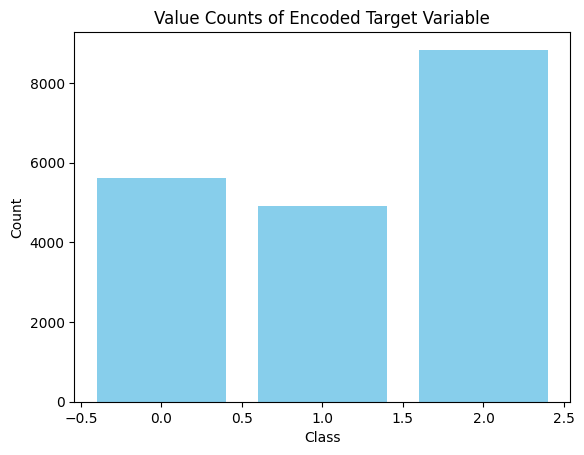

In [17]:
#BEFORE SMOTE CLASS IMBALANCE

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y_encoded' is a numpy.ndarray
unique, counts = np.unique(y_encoded, return_counts=True)

# Plotting
plt.bar(unique, counts, color='skyblue')
plt.title('Value Counts of Encoded Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


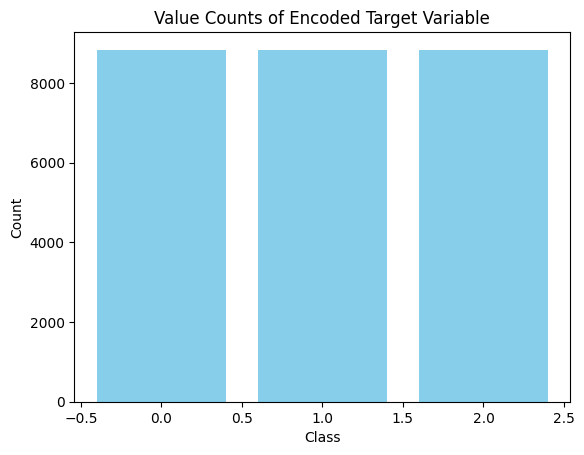

In [16]:
#AFTER SMOTE CLASS BALANCE

import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_resampled, return_counts=True)

plt.bar(unique, counts, color='skyblue')
plt.title('Value Counts of Encoded Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


Splitting data into training and test sets...

Training and evaluating models...

Training and evaluating models for AUC-ROC curves...

Logistic Regression Cross-validation Accuracy: 0.4634 (+/- 0.0077)
Logistic Regression Test Accuracy: 0.4697
Logistic Regression AUC-ROC: 0.5745

Support Vector Machine Cross-validation Accuracy: 0.5265 (+/- 0.0075)
Support Vector Machine Test Accuracy: 0.5325
Support Vector Machine AUC-ROC: 0.6936

Random Forest Cross-validation Accuracy: 0.6318 (+/- 0.0086)
Random Forest Test Accuracy: 0.6523
Random Forest AUC-ROC: 0.8365

Gradient Boosting Cross-validation Accuracy: 0.5318 (+/- 0.0060)
Gradient Boosting Test Accuracy: 0.5316
Gradient Boosting AUC-ROC: 0.6715

K-Nearest Neighbors Cross-validation Accuracy: 0.5321 (+/- 0.0085)
K-Nearest Neighbors Test Accuracy: 0.5535
K-Nearest Neighbors AUC-ROC: 0.7590

Neural Network Cross-validation Accuracy: 0.5139 (+/- 0.0101)
Neural Network Test Accuracy: 0.5252
Neural Network AUC-ROC: 0.6988

Extra Trees Cross-

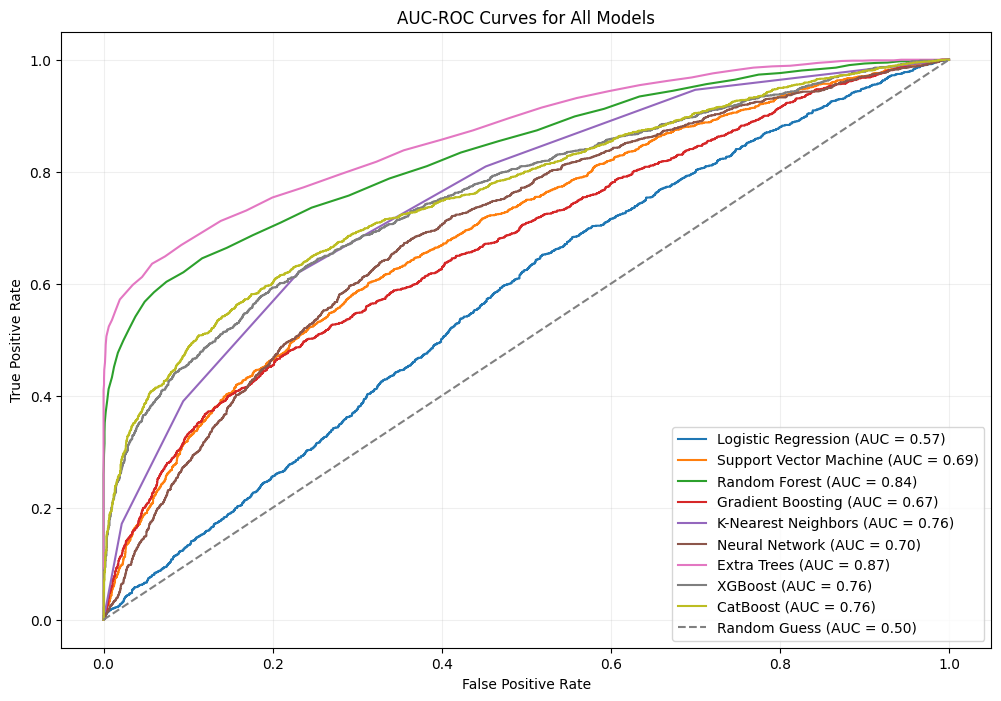


Models ranked by test accuracy:
Extra Trees: 0.6868
Random Forest: 0.6523
CatBoost: 0.6110
XGBoost: 0.5910
K-Nearest Neighbors: 0.5535
Support Vector Machine: 0.5325
Gradient Boosting: 0.5316
Neural Network: 0.5252
Logistic Regression: 0.4697


In [11]:
# ================================
# Model Training and Evaluation with AUC-ROC
# ================================

# Split data into training and test sets
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Support Vector Machine': SVC(probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss'),
    # 'LightGBM': LGBMClassifier(force_col_wise=True),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Train and evaluate models using cross-validation
print("\nTraining and evaluating models...")
results = {}
roc_data = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to train and evaluate models, including AUC-ROC computation
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate_model_with_auc(model_name, model, X_train, y_train, X_test, y_test, skf):
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1) if y_prob.ndim > 1 else roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return model_name, {
        'model': model.__class__.__name__,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_acc': acc,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

# Parallelize the model training and AUC computation
print("\nTraining and evaluating models for AUC-ROC curves...")
results_list = dict(Parallel(n_jobs=-1, backend="loky")(
    delayed(train_and_evaluate_model_with_auc)(name, model, X_train, y_train, X_test, y_test, skf)
    for name, model in models.items())
)

# Store results and ROC data
for name, result in results_list.items():
    print(f"\n{name} Cross-validation Accuracy: {result['cv_mean']:.4f} (+/- {result['cv_std']:.4f})")
    print(f"{name} Test Accuracy: {result['test_acc']:.4f}")
    print(f"{name} AUC-ROC: {result['roc_auc']:.4f}")
    results[name] = result['test_acc']
    roc_data[name] = result

# Plot AUC-ROC curves
plt.figure(figsize=(12, 8))
for model_name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{model_name} (AUC = {data['roc_auc']:.2f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.50)')
plt.title('AUC-ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

# Display models ranked by test accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nModels ranked by test accuracy:")
for name, acc in sorted_results:
    print(f"{name}: {acc:.4f}")


In [12]:
# ================================
# Hyperparameter Tuning for Best Model
# ================================

# Let's assume XGBoost performed the best
best_model_name = sorted_results[0][0]
print(f"\nHyperparameter Tuning for {best_model_name}...")

if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10, -1],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }
    model = LGBMClassifier()
elif best_model_name == 'CatBoost':
    param_grid = {
        'iterations': [500, 1000],
        'depth': [6, 10],
        'learning_rate': [0.01, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
    model = CatBoostClassifier(verbose=0)
else:
    # For other models, use generic parameters
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    model = models[best_model_name]

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters for {best_model_name}: {grid_search.best_params_}")

# Evaluate the best model
print(f"\nEvaluating Best {best_model_name} Model...")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")


Hyperparameter Tuning for Extra Trees...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters for Extra Trees: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluating Best Extra Trees Model...
              precision    recall  f1-score   support

          -1       0.69      0.74      0.72      1767
           0       0.77      0.68      0.72      1768
           1       0.64      0.66      0.65      1768

    accuracy                           0.69      5303
   macro avg       0.70      0.69      0.69      5303
weighted avg       0.70      0.69      0.69      5303

Accuracy Score: 0.6938


In [13]:
# ================================
# Prediction on New Data
# ================================

# For demonstration, let's predict the outcome of the next match in the dataset
print("\nPredicting outcome for a new match...")

# Assuming the next match is at index -1
new_match = match_cleaned.iloc[-1]

# Prepare the feature vector
new_match_features = new_match[existing_features].values.reshape(1, -1)
new_match_scaled = scaler.transform(new_match_features)

# Predict using the best model
prediction = best_model.predict(new_match_scaled)
result = label_encoder.inverse_transform(prediction)[0]
outcome = {1: 'Home Win', 0: 'Draw', -1: 'Away Win'}

print(f"Predicted Outcome: {outcome[result]}")

# ================================
# Conclusion
# ================================

print("\nNotebook execution completed successfully.")


Predicting outcome for a new match...
Predicted Outcome: Home Win

Notebook execution completed successfully.
